In [1]:
%pip install opencv-python matplotlib numpy scipy tqdm scikit-learn Rtree psycopg2 pandas

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
directory_path = os.path.join("F:/", "DB2_Proyect", "portraits")
images_names = os.listdir(directory_path)
print(images_names[0])
path = "D:\Semestre_2024_2_CS\BD_2\Projects\Proyecto3"
output_directory = os.path.join(path, "data")


10-luyjxyh.jpg


# Cargar los features globales para Rtree

In [2]:
file_name = "descriptors_color_global_opencv.npz"
load_path = os.path.join(os.getcwd(), "data",file_name)
features = np.load(load_path)




# Graficadora de resultados

In [3]:
import os
import matplotlib.pyplot as plt
from skimage import io

def display_images_in_grid(image_paths, grid_rows, grid_cols):
    """
    Muestra las imágenes en una cuadrícula de subplots con el nombre de la imagen como título.

    Parameters:
    image_paths (list): Lista de rutas de imágenes a mostrar.
    grid_rows (int): Número de filas en la cuadrícula.
    grid_cols (int): Número de columnas en la cuadrícula.
    """
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2))
    
    # Aplanar el arreglo de ejes para fácil iteración
    axes = axes.flatten()
    
    # Mostrar cada imagen en su posición correspondiente
    for i, image_path in enumerate(image_paths):
        
        if i < len(axes):  # Para evitar errores si hay más espacios que imágenes
            image = io.imread(image_path)
            
            # Determinar si la imagen es en escala de grises o a color
            if image.ndim == 2:
                # Escala de grises
                axes[i].imshow(image, cmap='gray')
            elif image.ndim == 3:
                # A color (RGB)
                axes[i].imshow(image)
            else:
                raise ValueError(f"La imagen {image_path} tiene un formato inesperado: {image.ndim} dimensiones.")
            
            # Extraer solo el nombre del archivo
            image_name = os.path.basename(image_path)
            
            # Establecer el título con el nombre de la imagen
            axes[i].set_title(image_name)
            axes[i].axis('off')
    
    # Desactivar cualquier subplot vacío
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
import os
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from skimage import io, color
import numpy as np
import cv2

def extract_global_lbp_features(image, P=8, R=1, method='uniform', bins=4):
    lbp_features = []
    for channel in range(3):  # RGB
        lbp = local_binary_pattern(image[:, :, channel], P=P, R=R, method=method)
        # Calcular histograma global
        hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalización
        lbp_features.extend(hist)
    return np.array(lbp_features)  # 3 canales * bins dimensiones

def extract_global_color_histogram(image, bins=4):
    color_hist = []
    for channel in range(3):  # RGB
        hist, _ = np.histogram(image[:, :, channel], bins=bins, range=(0, 256))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalización
        color_hist.extend(hist)
    return np.array(color_hist)  # 3 canales * bins dimensiones

def extract_global_hog_features_opencv(gray_image, orientations=6, pixels_per_cell=(64, 64), cells_per_block=(1, 1)):
    hog = cv2.HOGDescriptor(_winSize=(gray_image.shape[1] // pixels_per_cell[1] * pixels_per_cell[1],
                                      gray_image.shape[0] // pixels_per_cell[0] * pixels_per_cell[0]),
                            _blockSize=(pixels_per_cell[1] * cells_per_block[1],
                                        pixels_per_cell[0] * cells_per_block[0]),
                            _blockStride=(pixels_per_cell[1], pixels_per_cell[0]),
                            _cellSize=pixels_per_cell,
                            _nbins=orientations)
    hog_features = hog.compute(gray_image).flatten()
    if len(hog_features) > orientations:
        hog_features = np.mean(hog_features.reshape(-1, orientations), axis=0)
    elif len(hog_features) < orientations:
        hog_features = np.pad(hog_features, (0, orientations - len(hog_features)), 'constant')
    return hog_features

def process_image_global(image_path, orientations=6, pixels_per_cell=(64, 64), cells_per_block=(1, 1), 
                         P=8, R=1, lbp_bins=4, color_bins=4):
    image = io.imread(image_path)
    
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError(f"La imagen {image_path} no es RGB o no tiene 3 canales.")

    # Validar tamaño de la imagen (512x512)
    if image.shape[0] != 512 or image.shape[1] != 512:
        raise ValueError(f"La imagen {image_path} no tiene tamaño 512x512. Tamaño actual: {image.shape[:2]}")

    # Convertir a escala de grises
    gray_image = color.rgb2gray(image)
    gray_image_uint8 = (gray_image * 255).astype('uint8')

    # Extraer características globales
    hog_features = extract_global_hog_features_opencv(gray_image_uint8, orientations, pixels_per_cell, cells_per_block)
    lbp_features = extract_global_lbp_features(image, P=P, R=R, method='uniform', bins=lbp_bins)
    color_hist = extract_global_color_histogram(image, bins=color_bins)

    # Concatenar todas las características
    feature_vector = np.concatenate([hog_features, lbp_features, color_hist])

    # Validar tamaño del vector
    if feature_vector.shape[0] > 20:
        feature_vector = feature_vector[:20]
    elif feature_vector.shape[0] < 20:
        feature_vector = np.pad(feature_vector, (0, 20 - feature_vector.shape[0]), 'constant')

    return image_path, feature_vector

# Indice Rtree de python

In [11]:
from rtree import index
import numpy as np
from collections import defaultdict
from tqdm import tqdm

class RtreeSupportRAM:
    def __init__(self):
       
        # Initialize properties for a 16-dimensional R-tree
        p = index.Property()
        p.dimension = 20

        # Create an in-memory index
        print("Creating an in-memory R-tree index...")
        self.idx_ram = index.Index(properties=p)
        print("In-memory index created.")

        self.insertions_count = 0

    def insert(self, features):
        
        print("Starting insertion of features into the in-memory index...")
        for img_name, vector in tqdm(features.items(), desc="Inserting features"):
         
                # Ensure the vector is a list of floats
                vector = [float(coord) for coord in vector]

                vector_id = img_name
                unique_id = hash(vector_id)

                bbox = tuple(vector) + tuple(vector)

                
                self.idx_ram.insert(id=unique_id, coordinates=bbox, obj=vector_id)

                self.insertions_count += 1

        print(f"Inserted {self.insertions_count} vectors into the in-memory index.")

    def KNN_LOCAL(self, vector, k):
        
        # Ensure the vector is a list of floats
        vector = [float(coord) for coord in vector]

        # Create a bounding box for the query vector (min and max are the same)
        bbox = tuple(vector) + tuple(vector)

        # Query the in-memory index for k nearest neighbors
        results = list(self.idx_ram.nearest(coordinates=bbox, num_results=k, objects=True))

        # Extract the identifiers of the nearest neighbors
        vector_ids = [res.object + '.jpg' for res in results]
        return vector_ids

    def KNN_GLOBAL(self, query_matrix, k):
       
        image_votes = defaultdict(int)
        print("Starting global KNN query...")
        for vector in tqdm(query_matrix, desc="Processing local descriptors"):
            # Find k nearest neighbors for each local vector
            vector_k_neighbors = self.KNN_LOCAL(vector, k)
            for neighbor in vector_k_neighbors:
                img_name = neighbor[0]  # Extract image name from (img_name, idx)
                image_votes[img_name] += 1  # Increment vote for the image

        # Sort images by the number of votes in descending order
        sorted_images = sorted(image_votes.items(), key=lambda x: x[1], reverse=True)
        # Return the top k images
        top_k_images = [img for img, votes in sorted_images[:k]]
        return top_k_images


In [8]:
tree_wrapper = RtreeSupportRAM()
tree_wrapper.insert(features)


Creating an in-memory R-tree index...
In-memory index created.
Starting insertion of features into the in-memory index...


Inserting features: 100%|██████████| 302652/302652 [16:17<00:00, 309.54it/s]

Inserted 302652 vectors into the in-memory index.


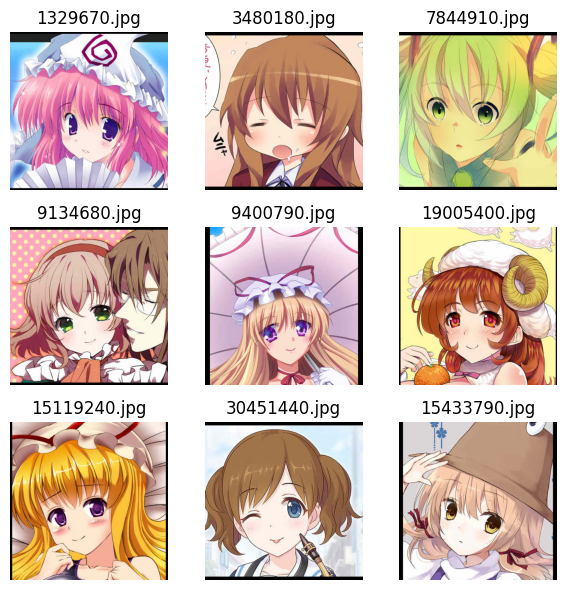

In [24]:
import os
query_path = os.path.join(directory_path , "1329670.jpg")
_,query = process_image_global(query_path)
result  = tree_wrapper.KNN_LOCAL(query,10)
result = [os.path.join(directory_path,name+".jpg") for name in result ]
display_images_in_grid(result , 3 ,3 )

# USING SQL

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import rtree
import pandas as pd 

# Conectar a postgres

In [ ]:
import psycopg2


# Conexión a la base de datos
conn= psycopg2.connect(
        host="localhost",      # Cambiar si el host es diferente 
        database="",    # cambiar a la base de uso
        user="postgres",       # cambiar al user donde se haran las pruebas 
        password="",  # cambiar al password de uso
        port="5432"
    )

schema = "project_anime"

try:
   

    cursor = conn.cursor()

    
    cursor.execute("SELECT version();")

    version = cursor.fetchone()
    print(f"Versión de PostgreSQL: {version}")

except Exception as error:
    print(f"Error al conectar con PostgreSQL: {error}")




def ejecutar_consulta(sql_str, select=False):
    try:
        # Crear un cursor para ejecutar las consultas
        cur = conn.cursor()
        # Ejecutar la consulta
        cur.execute(sql_str)
        # Aplicar commit si la consulta es INSERT, UPDATE o DELETE
        conn.commit()

        # Manejo para consultas SELECT
        if select:
            rows = cur.fetchall()
            df = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])
            return df, rows
    except Exception as e:
        print(f"Error: {e}")
        conn.rollback()  # Revertir si hay un error
    finally:
        cur.close()


Versión de PostgreSQL: ('PostgreSQL 15.2, compiled by Visual C++ build 1914, 64-bit',)


# Crear extension cube

In [31]:
sql_str = f"""
CREATE SCHEMA IF NOT EXISTS {schema};

CREATE EXTENSION IF NOT EXISTS cube SCHEMA {schema};

CREATE TABLE IF NOT EXISTS {schema}.faces (
    id SERIAL,
    image_name VARCHAR(20) NOT NULL,
    vector {schema}.cube, 
    vector_idx {schema}.cube,
    PRIMARY KEY (id, image_name)
);
"""
ejecutar_consulta(sql_str)

# Definir querys especificas

In [34]:
def set_path():
    sql_str=f"""

    SET search_path to {schema};
    """
    ejecutar_consulta(sql_str)

def delete():
       sql_delete = f"DELETE FROM {schema}.faces;"
       ejecutar_consulta(sql_delete)



# PASAR DATA A CSV

In [29]:
import csv
import os
from tqdm import tqdm  # Asegúrate de importar tqdm si lo estás usando

def export_to_csv(features, csv_file):
 
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)

    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        # Escribir encabezado del CSV
        writer.writerow(['image_name', 'vector'])
        for image_name, single_vect in tqdm(features.items(), desc="Exporting features to CSV"):
                # Convertir el vector a formato de texto
                vect_str = ','.join(map(str, single_vect))
                # Escribir la fila en el archivo CSV
                writer.writerow([image_name, vect_str])



export_to_csv(features, os.path.join(output_directory, 'features_for_rtree.csv'))



Exporting features to CSV: 100%|██████████| 302652/302652 [15:36<00:00, 323.09it/s]


- Ejectuar el script Rtree_Script.sql

In [37]:

def execute_single_query(vector , k=5):
    set_path()
    vector_str = ', '.join(map(str, vector))
    sql_str =f"""
            SELECT  id , image_name,
            cube_distance(vector_idx, '({vector_str})') as D
            FROM faces
            ORDER BY vector_idx <-> '({vector_str})'
            LIMIT {k};
        """
    _  , row = ejecutar_consulta(sql_str , select=True)
    return [ os.path.join(directory_path,element +'.jpg') for id , element , sim in row  ]



# QUERY

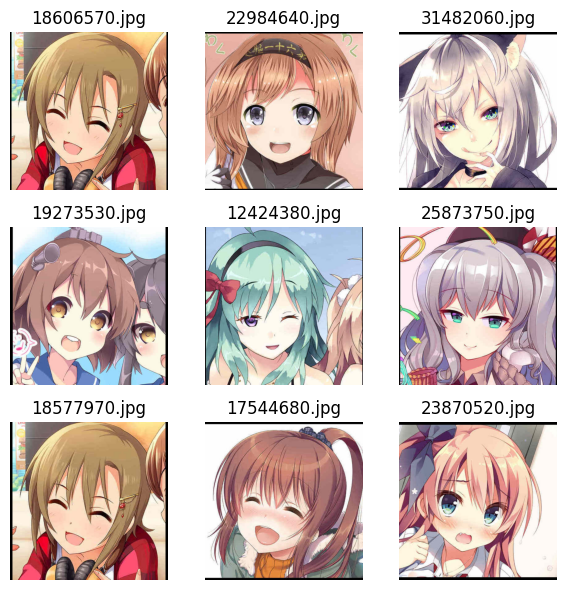

In [39]:
import os
query_path = os.path.join(directory_path , "18606570.jpg")
_, query = process_image_global(query_path)
result = execute_single_query(query,10)
display_images_in_grid(result,3,3)
